In [2]:
import os

# 指定文件夹路径
download_save_path = 'E:/Dataset/wind_shear/Data_Download'
exception_save_path = '../Dataset/Exception_Data'
plt_save_path = '../result/WSHR/figures'

# 获取文件夹下的所有文件名称
dowload_folder_names = [item for item in os.listdir(download_save_path) if os.path.isdir(os.path.join(download_save_path, item))]
exception_folder_names = [item for item in os.listdir(exception_save_path) if os.path.isdir(os.path.join(exception_save_path, item))]
instruction_folder_names = ["@Instructions"]

# 生成所有文件夹路径
dowload_folder_paths = [os.path.join(download_save_path, item) for item in dowload_folder_names]
exception_folder_paths = [os.path.join(exception_save_path, item) for item in exception_folder_names]

In [17]:
# 读取异常文件，捕捉异常时段，生成统计分布
from scipy.io import loadmat
import numpy as np

# 规定WSHR异常值
wshr_e_value = 0

# 初始化WSHR异常时间字典
wshr_warn_time_dict = {}

for e_folder_path in exception_folder_paths:
    # 读取当前异常文件夹下所有文件路径
    e_mat_paths = [os.path.join(e_folder_path, item) for item in os.listdir(e_folder_path) if item.endswith('.mat')]
    for e_mat_path in e_mat_paths:
        # 读取当前异常文件
        e_mat = loadmat(e_mat_path)

        # 捕捉WSHR变量值为异常的时间段
        wshr = e_mat['WSHR']
        wshr_data, wshr_rate = wshr[0][0][0], wshr[0][0][1][0][0]
        # print(len(wshr_data))
        wshr_warn_time_list = [t if t<=len(wshr_data)/2 else t-len(wshr_data) for t in np.where(wshr_data==wshr_e_value)[0]]
        
        e_mat_marker = e_mat_path.split('\\')[-2] + '/' + e_mat_path.split('\\')[-1]
        wshr_warn_time_dict[e_mat_marker] = wshr_warn_time_list
#     break
# break

In [40]:
wshr_len_list = []
for e_folder_path in exception_folder_paths:
    # 读取当前异常文件夹下所有文件路径
    e_mat_paths = [os.path.join(e_folder_path, item) for item in os.listdir(e_folder_path) if item.endswith('.mat')]
    for e_mat_path in e_mat_paths:
        # 读取当前异常文件
        e_mat = loadmat(e_mat_path)

        # 捕捉WSHR变量值为异常的时间段
        wshr = e_mat['WSHR']
        wshr_data, wshr_rate = wshr[0][0][0], wshr[0][0][1][0][0]

        wshr_len_list.append(len(wshr_data))

print(np.max(wshr_len_list), np.min(wshr_len_list), np.mean(wshr_len_list), np.median(wshr_len_list))

16336 4 2759.2893809763464 842.0


WSHR warns in most cases at: [0 1 2]


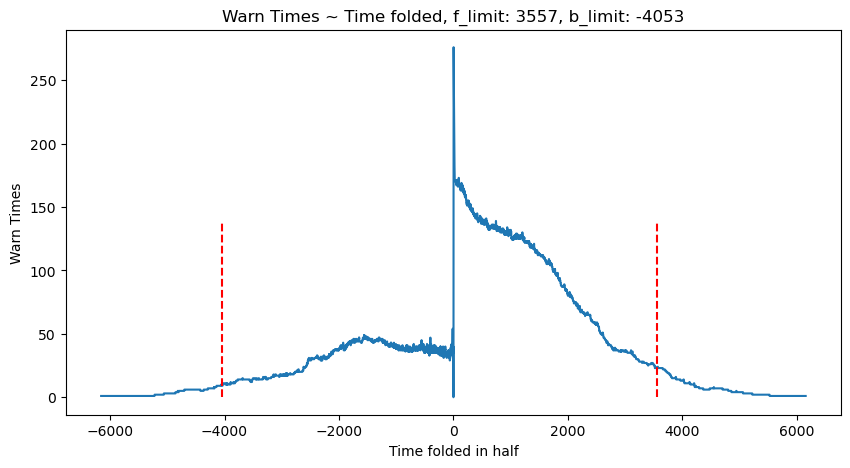

In [64]:
from collections import Counter
from matplotlib import pyplot as plt

# 初始化计数器
time_counter = Counter()

for e_mat_marker, e_warn_time_list in wshr_warn_time_dict.items():
    time_counter.update(Counter(e_warn_time_list))

sorted_indices = np.argsort(list(time_counter.keys()))
x_warn_time, y_times = np.array(list(time_counter.keys()))[sorted_indices], np.array(list(time_counter.values()))[sorted_indices]

# 提出高频数异常时刻
# max_times_idx = np.where(y_times==np.max(y_times))[0]
max_times_idx = np.where(y_times > 2000)[0]
print(f"WSHR warns in most cases at: {x_warn_time[max_times_inx]}")
# x_warn_time = np.delete(x_warn_time, max_times_idx)
# y_times = np.delete(y_times, max_times_idx)
y_times[max_times_idx] = 0

# 航程开始/结束各自计算给定比例的时刻阈值
zero_idx = np.where(x_warn_time == 0)[0][0]
limit_percent = 0.95

f_half_times, b_half_times = np.sum(y_times[x_warn_time > 0]), np.sum(y_times[x_warn_time < 0])
limit_f_times, limit_b_times = int(f_half_times * limit_percent), int(b_half_times * limit_percent)
count_f_times, count_b_times = 0, 0
limit_f_idx, limit_b_idx = 0, 0
for idx in range(zero_idx, len(x_warn_time)):
    count_f_times += y_times[idx]
    if count_f_times > limit_f_times:
        limit_f_idx = x_warn_time[idx]
        break
for idx in range(zero_idx, 0, -1):
    count_b_times += y_times[idx]
    if count_b_times > limit_b_times:
        limit_b_idx = x_warn_time[idx]
        break

# WSHR异常时间可视化
plt.figure(figsize=(10, 5))
plt.plot(x_warn_time, y_times)
plt.vlines(limit_f_idx, 0, np.max(y_times/2), colors='r', linestyles='--', label='f_limit')
plt.vlines(limit_b_idx, 0, np.max(y_times/2), colors='r', linestyles='--', label='b_limit')
plt.xlabel("Time folded in half")
plt.ylabel("Warn Times")
plt.title(f"Warn Times ~ Time folded, f_limit: {limit_f_idx}, b_limit: {limit_b_idx}")
plt.show()